In [1]:
import os
import json
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
from torchvision.transforms import v2 as T

from transformers import DetrImageProcessor, DetrForObjectDetection
import numpy as np


In [1]:
class CustomDataset:
    def __init__(self, folder_path, transforms=None):
        self.folder_path = folder_path
        self.transforms = transforms
        self.data_pairs = self._load_data_pairs()
        self.image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

    def _load_data_pairs(self):
        image_files = []
        json_files = {}
        data_pairs = []

        # 폴더를 재귀적으로 검색하여 이미지 파일과 JSON 파일 목록을 생성
        for root, _, files in os.walk(self.folder_path):
            for file in files:
                if file.endswith((".jpg", ".jpeg", ".png")):
                    image_files.append(os.path.join(root, file))
                elif file.endswith(".json"):
                    json_files[os.path.splitext(file)[0]] = os.path.join(root, file)

        # 진행률 표시줄 추가
        for image_file_path in tqdm(image_files, desc="Matching image and JSON files"):
            # 이미지 파일 이름에서 확장자를 제외한 부분 가져오기
            image_name = os.path.splitext(os.path.basename(image_file_path))[0]
        
            # 해당 이미지 파일과 매칭되는 JSON 파일 찾기
            if image_name in json_files:
                json_file_path = json_files[image_name]
                data_pairs.append((image_file_path, json_file_path))
            else:
                print(f"JSON file not found for image: {image_file_path}")
        
        return data_pairs

    def create_detr_target(self, json_data):
        annotations = json_data['annotations']
        categories = {cat['id']: cat['name'] for cat in json_data['categories']}
        
        # 한글에서 영어로 라벨을 매핑하는 딕셔너리
        label_mapping = {'화방': 0, '줄기': 1, '잎': 2, '열매': 3}  # 예시, 실제 매핑에 맞게 수정 필요

        height = 1960  # 로즈 테스트시 고정값 사용
        width = float(json_data['images'][0]['width'])

        target = {
            'boxes': [],
            'class_labels': [],
        }

        ann = annotations[0]  # 어노테이션 리스트에서 첫 번째 어노테이션을 선택

        bbox = ann['bbox']  # 바운딩 박스 좌표
        obj_name = categories[ann['category_id']]  # 객체 이름

        # 한글 카테고리 이름을 영어로 변환하여 매핑된 정수 레이블 얻기
        label = label_mapping.get(obj_name, -1)  # 없는 경우에 대한 처리

        if label == -1:
            # 처리할 수 없는 경우 스킵하거나 예외 처리 필요
            pass

        # 바운딩 박스 좌표 변환 및 정규화
        x_min = bbox[1] / width
        y_min = (height - (bbox[0] + bbox[2])) / height
        box_width = bbox[3] / width
        box_height = bbox[2] / height

        # target 딕셔너리에 정보 추가
        target = {
            'boxes': [[x_min, y_min, box_width, box_height]],  # 바운딩 박스 좌표
            'class_labels': [label],  # 객체의 정수 레이블
        }

        # 리스트를 텐서로 변환
        target['boxes'] = torch.tensor(target['boxes'], dtype=torch.float32)
        target['class_labels'] = torch.tensor(target['class_labels'], dtype=torch.int64)  # 클래스 레이블을 정수로 변환

        return target

    def preprocess_image(self, image):
        img = self.image_processor(image, return_tensors="pt")
        images = img['pixel_values'].clone().detach().to(torch.float32)
        images = images.permute(0, 1, 3, 2)  # (batch_size, channels, height, width) 순으로 변환
        return images
        
    def __getitem__(self, index):
        img_path, json_path = self.data_pairs[index]

        with open(json_path, 'r') as f:
            json_data = json.load(f)

        img = Image.open(img_path).convert("RGB")

        images = self.preprocess_image(img)  # (1, channels, height, width) 형태로 반환
        images = images.squeeze(0)  # 첫 번째 차원을 제거하여 (channels, height, width) 형태로 변환

       
        target = self.create_detr_target(json_data)

        return images, target

    def __len__(self):
        return len(self.data_pairs)

In [2]:
folder_path = "./Dataset"
# 데이터셋 객체 생성
dataset1 = CustomDataset(folder_path)

# 데이터셋의 첫 번째 샘플에 대한 타겟 정보 확인
sample_img, sample_target = dataset1[10]
# 타겟의 모양과 유형을 출
print("target:", sample_target)
print("shape of target:", sample_target['boxes'].shape)

print("img:", sample_img)
print("Type of img:", type(sample_img))
print("shape of img:", sample_img.shape)

print(sample_target["class_labels"])


NameError: name 'os' is not defined

In [135]:
# # DETR 모델에 입력하기 위한 준비
# inputs = {
#     'pixel_values': sample_img.unsqueeze(0),  # 배치 차원 추가
#     'labels': [sample_target]  # 타겟을 리스트로 감싸서 전달
# }

In [136]:
train_path = "./dataset/train"
val_path="./dataset/val"
test_path="./dataset/test"

In [137]:
print(os.path.exists(train_path))
print(os.path.exists(val_path))
print(os.path.exists(test_path))

True
True
True


In [138]:
def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets


In [151]:
normalize = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transform_train = T.Compose([
    T.RandomResizedCrop(256),
    T.RandomHorizontalFlip(),
    normalize
])

transform_val = T.Compose([
    T.Resize(256),
    T.CenterCrop(256),
    normalize
])

# 데이터셋 객체 생성
dataset = CustomDataset(train_path, transforms=transform_train)
dataset_val = CustomDataset(val_path, transforms=transform_val)
dataset_test = CustomDataset(test_path, transforms=normalize)  # 테스트 데이터는 정규화만 수행합니다.

# Subset 생성
indices = torch.randperm(len(dataset)).tolist()
train_indices = indices[:-100]
val_indices = indices[-100:]

# Subset으로 학습, 검증 데이터셋 생성
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset_val, val_indices)

# 데이터로더 정의
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
     batch_size=2,
    collate_fn=collate_fn
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    shuffle=False,
    batch_size=2,
    collate_fn=collate_fn
)

test_loader = torch.utils.data.DataLoader(
    dataset_test,
    shuffle=False,

    collate_fn=collate_fn
)


Matching image and JSON files: 100%|██████████| 56/56 [00:00<00:00, 56030.78it/s]


In [152]:
# 디버깅을 위해 배치 데이터를 확인합니다.
for batch in train_loader:
    images, targets = batch
    print("Images Shape:", images.shape)
    print("Targets:", targets)
    break

Images Shape: torch.Size([2, 3, 1333, 648])
Targets: [{'boxes': tensor([[0.2555, 0.2183, 0.3355, 0.6083]]), 'class_labels': tensor([2])}, {'boxes': tensor([[0.5043, 0.2589, 0.3515, 0.1776]]), 'class_labels': tensor([1])}]


In [153]:
import math
import sys
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import DetrImageProcessor
import detr.util.misc as utils

In [164]:
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
# 장치 설정 (GPU 사용 가능 여부 확인)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [165]:
# 하이퍼파라미터 설정
num_epochs = 10
learning_rate = 0.0001
batch_size = 2
print_freq = 10

# 옵티마이저 설정
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


model.to(device)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

In [156]:
import torch
import torch.nn.functional as F
from torchvision.ops.boxes import box_iou
from scipy.optimize import linear_sum_assignment

In [157]:
def generalized_box_iou(boxes1, boxes2):
    """
    Compute generalized IoU between two sets of boxes.
    """
    # Calculate the intersection and union areas
    inter = box_iou(boxes1, boxes2)
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])
    
    union = area1[:, None] + area2 - inter
    
    # Calculate the enclosing box area
    min_xy = torch.min(boxes1[:, None, :2], boxes2[:, :2])
    max_xy = torch.max(boxes1[:, None, 2:], boxes2[:, 2:])
    
    enclosing = (max_xy - min_xy).prod(dim=2)
    
    # Calculate generalized IoU
    return inter / union - (enclosing - union) / enclosing

def hungarian_matcher(pred_boxes, target_boxes):
    """
    Perform Hungarian matching between predicted and target boxes.
    """
    # Compute the cost matrix based on generalized IoU
    cost_matrix = -generalized_box_iou(pred_boxes, target_boxes)
    
    # Perform Hungarian matching
    indices = linear_sum_assignment(cost_matrix.cpu().detach().numpy())
    
    return indices

def compute_loss(output, targets):
    # 모델 출력에서 박스 예측과 클래스 예측 추출
    predicted_boxes = output["pred_boxes"].view(-1, 4)
    predicted_logits = output["logits"].view(-1, output["logits"].size(-1))
    
    # 타겟에서 박스와 클래스 추출
    target_boxes = torch.cat([t["boxes"] for t in targets], dim=0)
    target_labels = torch.cat([t["labels"] for t in targets], dim=0)
    
    # Perform Hungarian matching
    indices = hungarian_matcher(predicted_boxes, target_boxes)
    
    # Extract the matched indices
    matched_pred_indices = torch.tensor(indices[0], dtype=torch.long, device=predicted_boxes.device)
    matched_target_indices = torch.tensor(indices[1], dtype=torch.long, device=predicted_boxes.device)
    
    # 손실 계산
    loss_boxes = F.mse_loss(predicted_boxes[matched_pred_indices], target_boxes[matched_target_indices])
    loss_labels = F.cross_entropy(predicted_logits[matched_pred_indices], target_labels[matched_target_indices])
    
    # 전체 손실 반환
    return loss_boxes + loss_labels


In [171]:
import torch
from tqdm import tqdm

# 모델 훈련 반복문
best_loss = float('inf')  # 매우 큰 초기 손실값 설정
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        targets = [{'boxes': t['boxes'].to(device), 'class_labels': t['class_labels'].to(device)} for t in targets]

        # 모델 호출 후 손실 계산
        outputs = model(images, labels=targets)
        loss_dict = outputs.loss_dict
        losses = sum(loss for loss in loss_dict.values())

        # 역전파 및 옵티마이저로 모델 업데이트
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    # 한 에폭 종료 후 평균 손실 출력
    avg_loss = total_loss / len(train_loader)
    print(f"에폭 {epoch+1}/{num_epochs}, 총 손실: {avg_loss}")

    # 검증 데이터셋을 사용한 모델 평가
    model.eval()
    # 평가 지표 계산 등 추가 필요

    # 조기 종료 기준: 최소 손실 기준으로 모델 저장
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict()
        torch.save(best_model_state, 'detr_model.pth')  # 모델 저장

    # 예시로 손실이 감소하지 않으면 조기 종료 조건으로 설정
    if avg_loss > best_loss:
        print(f"조기 종료: 에폭 {epoch+1}, 최적 손실: {best_loss}")
        break

# 최종 학습 완료 후 저장된 최적 모델 불러오기
if best_model_state is not None:
    model.load_state_dict(best_model_state)


Epoch 1/10:  10%|█         | 9/88 [00:04<00:41,  1.88it/s]


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn.functional as F
from collections import defaultdict
import math
import sys
import detr.util.misc as utils  # 필요한 경우 utils 모듈을 import해야 합니다.

def train_one_epoch(model, optimizer, train_loader, device, clip_max_norm=0.5, print_freq=10):
    model.train()
    metric_logger = defaultdict(float)
    iteration = 0
    
    for samples, targets in train_loader:
        samples = list(sample.to(device) for sample in samples)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(samples, targets)
        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)  # utils 모듈이 정의되어 있어야 합니다.
        loss_dict_reduced_unscaled = {f'{k}_unscaled': v.item()
                                      for k, v in loss_dict_reduced.items()}
        loss_weight = {k: 1.0 for k in loss_dict_reduced.keys()}  # 예시로 모든 손실 가중치를 1.0으로 설정
        losses_reduced_scaled = sum(loss_dict_reduced[k] * loss_weight[k]
                                    for k in loss_dict_reduced.keys() if k in loss_weight)

        loss_value = losses_reduced_scaled.item()
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        losses.backward()
        if clip_max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
        optimizer.step()

        for k, v in loss_dict_reduced.items():
            metric_logger[k] += v.item()
        metric_logger['loss'] += loss_value
        iteration += 1
        if print_freq is not None and iteration % print_freq == 0:
            print(f"Iteration: {iteration}, Loss: {loss_value}")
            print({k: f"{v / iteration:.4f}" for k, v in metric_logger.items()})

    return {k: v / len(train_loader) for k, v in metric_logger.items()}


In [130]:
import torch
import os
import detr.util.misc as utils  # 이 부분에는 적절한 유틸리티 파일이나 패키지를 임포트해야 합니다.

def evaluate_custom(model, criterion, postprocessors, data_loader, device):
    model.eval()
    criterion.eval()

    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('class_error', utils.SmoothedValue(window_size=1, fmt='{value:.2f}'))
    header = 'Test:'

    for samples, targets in metric_logger.log_every(data_loader, 10, header):
        samples = samples.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(samples)
        loss_dict = criterion(outputs, targets)
        weight_dict = criterion.weight_dict

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        loss_dict_reduced_scaled = {k: v * weight_dict[k]
                                    for k, v in loss_dict_reduced.items() if k in weight_dict}
        loss_dict_reduced_unscaled = {f'{k}_unscaled': v
                                      for k, v in loss_dict_reduced.items()}
        metric_logger.update(loss=sum(loss_dict_reduced_scaled.values()),
                             **loss_dict_reduced_scaled,
                             **loss_dict_reduced_unscaled)
        metric_logger.update(class_error=loss_dict_reduced['class_error'])

        orig_target_sizes = torch.stack([t["orig_size"] for t in targets], dim=0)
        results = postprocessors['bbox'](outputs, orig_target_sizes)
        if 'segm' in postprocessors.keys():
            target_sizes = torch.stack([t["size"] for t in targets], dim=0)
            results = postprocessors['segm'](results, outputs, orig_target_sizes, target_sizes)
        res = {target['image_id'].item(): output for target, output in zip(targets, results)}

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)

    stats = {k: meter.global_avg for k, meter in metric_logger.meters.items()}

    return stats

In [ ]:
class PostProcess(nn.Module):
    """ This module converts the model's output into the format expected by the coco api"""
    @torch.no_grad()
    def forward(self, outputs, target_sizes):
        """ Perform the computation
        Parameters:
            outputs: raw outputs of the model
            target_sizes: tensor of dimension [batch_size x 2] containing the size of each images of the batch
                          For evaluation, this must be the original image size (before any data augmentation)
                          For visualization, this should be the image size after data augment, but before padding
        """
        out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']

        assert len(out_logits) == len(target_sizes)
        assert target_sizes.shape[1] == 2

        prob = F.softmax(out_logits, -1)
        scores, labels = prob[..., :-1].max(-1)

        # convert to [x0, y0, x1, y1] format
        boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
        # and from relative [0, 1] to absolute [0, height] coordinates
        img_h, img_w = target_sizes.unbind(1)
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
        boxes = boxes * scale_fct[:, None, :]

        results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]

        return results

In [ ]:
print("Start training")
for epoch in range(num_epochs):
    # 훈련
    train_stats = train_one_epoch(model, compute_loss, data_loader_train, optimizer, device, epoch, args.clip_max_norm)

    # 체크포인트 저장
    if (epoch + 1) % 5 == 0:
        checkpoint_path = f"checkpoint_epoch_{epoch + 1}.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_stats['loss'],  # 훈련 손실
        }, checkpoint_path)

    # 평가
    test_stats = evaluate_custom(model, compute_loss, postprocessors, data_loader_val, dataset_val, device, output_dir)
    print(f"Epoch {epoch + 1} - Test stats: {test_stats}")

print("Training finished.")

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def normalize_channel(channel):
    """채널을 0-1 범위로 정규화합니다."""
    channel_min = channel.min()
    channel_max = channel.max()
    return (channel - channel_min) / (channel_max - channel_min)

def plot_detection(images, target):
    fig, ax = plt.subplots(1)
    
    # 이미지 추출 및 정규화
    images = images['pixel_values'].squeeze(0).cpu().numpy()  # 배치 차원 제거 후 numpy 배열로 변환
    if images.shape[0] == 4:  # 만약 이미지가 RGBA 포맷이라면
        images = images[:3, ...]  # 알파 채널 제거하여 RGB 채널만 선택
    
    # 채널별로 독립적으로 정규화
    r_channel = normalize_channel(images[0, ...])
    g_channel = normalize_channel(images[1, ...])
    b_channel = normalize_channel(images[2, ...])
    
    # 정규화된 채널을 다시 합쳐서 3D 배열로 만듭니다.
    images_normalized = np.stack([r_channel, g_channel, b_channel], axis=0)
    
    # 이미지를 [0, 255] 범위로 변환하고 uint8 형식으로 변환
    images_normalized = (images_normalized * 255).astype(np.uint8)
    
    # 채널 순서를 변경하여 이미지 표시
    image_rgb = images_normalized.transpose(1, 2, 0)
    
    # 정규화된 채널 확인
    # print("R channel min and max values after normalization:", r_channel.min(), r_channel.max())
    # print("G channel min and max values after normalization:", g_channel.min(), g_channel.max())
    # print("B channel min and max values after normalization:", b_channel.min(), b_channel.max())

    ax.imshow(image_rgb)

    boxes = target['boxes'].cpu().numpy()
    labels = target['labels']

    height, width = images.shape[1], images.shape[2]  # 이미지의 높이와 너비 가져오기

    for box, label in zip(boxes, labels):
        x_min, y_min, box_width, box_height = box
        x_min *= width
        y_min *= height
        box_width *= width
        box_height *= height

        rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # 레이블 표시
        plt.text(x_min, y_min, str(label), color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

c:\Users\User\anaconda3\envs\py3_11\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


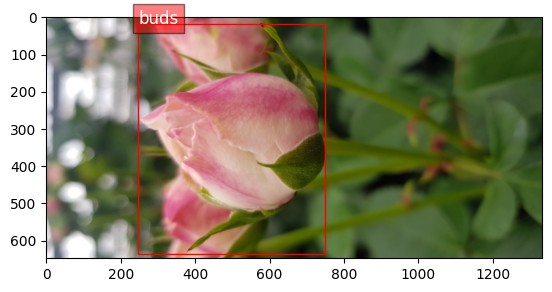

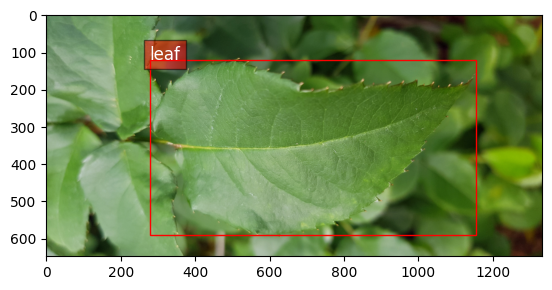

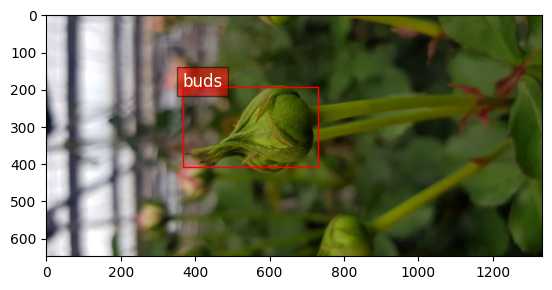

In [16]:
# 데이터셋 내용 확인 및 시각화
for i in range(len(dataset)):
    img, target = dataset[i]
    plot_detection(img, target)
    if i == 2:  # 예시로 처음 3개 항목만 확인
        break